In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from unidecode import unidecode
import seaborn as sns
import warnings
from matplotlib.font_manager import FontProperties


%matplotlib notebook
warnings.filterwarnings('ignore')

## Getting a List of All Right Backs

In [34]:
df = pd.read_table('RB.txt', skiprows = 0, header = None)
df = df.fillna(axis = 'index', method = 'ffill')
df = df.drop_duplicates(subset = 0, keep = 'last')

In [35]:
chng = {
    0 : 'Player',
    1:'Country',
    5:'Age',
    7:'Club'
}

cols = list(chng.values())

In [36]:
df = df.rename(axis = 'columns', mapper = chng)[cols]
df.to_csv('RB2019.csv')

In [37]:
#If you want more, start from the next page of 
# https://www.fifaindex.com/players/8/?position=3&order=desc
# and paste it into RB.txt

## Getting and Cleaning the Statistics

In [38]:
stats = pd.read_csv('RBStats2019.csv')
stats = stats.set_index('Player Name')

In [39]:
fdf = df.join(stats, on = 'Player')

Need to Convert the foreign characters to english

In [40]:
names = df['Player'].values

#Decoding and concerting to plain text, and having dictionaries to convert between
plydict = {i: unidecode(i) for i in names}
realdict = {unidecode(i): i for i in names}
df['Player'] = list(plydict.values())

Mapping Single Named Players with Two Names

In [41]:
#All the Players who are there in the stats dataset but NOT in Right Back Dataset
missing = fdf['Team'].isna()

#All the players in the stats dataset
substr_list = stats.index.values.astype('str')

#All Player in RB dataset
names = list(plydict.values())

In [42]:
conv = {}

#For all players in the stats dataset
for i in substr_list:
    
    #Get Last Name
    s = i.split()[-1]
    
    #For all player in the RB Dataset
    for x in names:
        
        if x == s:
            conv[x] = i

In [43]:
df['Player'] = df['Player'].replace(conv)
fdf = df.join(stats, on = 'Player')

Getting Players with data only

In [44]:
missing = fdf['Team'].isna()
fdf = fdf[~missing]

Combining league and UCL data

In [45]:
fdf.columns

Index(['Player', 'Country', 'Age', 'Club', 'Team', 'League', 'POS', 'GP',
       'MIN', 'Y', 'YR', 'R', 'A', 'SA', 'CR', 'ACR', 'CC', 'FS', 'P', 'AP',
       'ACRO', 'BCC', 'DR', 'APW', 'TBOX', 'ECL'],
      dtype='object')

In [14]:
cols = [
    'Player', 'Country', 'Age', 'Club','MIN',
    
    #Attacking Stats
    'A',
    #'SA',
    'ACR',
    'FS',
    'CR',
    'AP',
    'ACRO',
    'CC',
    'P',
    #'BCC',
    'DR',
    #'APW',
    'TBOX'
]


adf = fdf.groupby(cols[:4])[cols[4:]].sum()

#Greater than 900 Minutes
logic = adf['MIN'] > 900
adf = adf[logic]


#Crossing %
acc_crosses = adf['ACR'] + adf['ACRO']
crosses = adf['CR']
adf['CRrat'] = (acc_crosses/crosses) * acc_crosses
cols = cols + ['CRrat']

#Passing %
adf['P%'] = (adf['P']/adf['AP']) * 100
cols = cols + ['P%']


original_df = adf.copy()

rm =['CR', 'ACR', 'ACRO', 'AP', 'P']
for i in rm:
    cols.remove(i)


adf = adf.reset_index()
adf = adf[cols]

In [15]:
cols[6:-1]

['FS', 'CC', 'DR', 'TBOX', 'CRrat']

In [16]:
adf.columns

Index(['Player', 'Country', 'Age', 'Club', 'MIN', 'A', 'FS', 'CC', 'DR',
       'TBOX', 'CRrat', 'P%'],
      dtype='object')

In [17]:
adf.sort_values(by = 'DR', ascending=False).head(10)

,Player,Country,Age,Club,MIN,A,FS,CC,DR,TBOX,CRrat,P%
130,Youcef Atal,Algeria,22.0,OGC Nice,2171.0,0.0,58.0,22.0,96.0,95.0,5.157143,82.944915
26,Daniel Caligiuri,Italy,31.0,Schalke,3362.0,3.0,44.0,69.0,74.0,77.0,19.380734,69.393718
58,Joao Cancelo,Portugal,24.0,Juventus,2446.0,5.0,33.0,42.0,71.0,57.0,24.801527,85.296075
100,Ricardo Pereira,Portugal,25.0,Leicester City,3125.0,6.0,48.0,33.0,68.0,79.0,8.653846,78.016960
104,Ruben Pena,Spain,27.0,SD Eibar,2673.0,2.0,34.0,44.0,62.0,37.0,46.296296,71.460341
0,Aaron Wan-Bissaka,England,21.0,Crystal Palace,3135.0,3.0,16.0,14.0,61.0,30.0,10.285714,73.047210
17,Bouna Sarr,France,27.0,OM,2244.0,1.0,32.0,30.0,55.0,30.0,20.644860,85.174954
28,Danilo,Brazil,27.0,Manchester City,6324.0,0.0,75.0,31.0,51.0,69.0,9.333333,83.170872
1,Achraf Hakimi,Morocco,20.0,Dortmund,2110.0,7.0,44.0,17.0,43.0,45.0,4.654545,85.858586
65,Joshua Kimmich,Germany,24.0,FC Bayern,3690.0,15.0,66.0,98.0,40.0,67.0,41.953177,90.420561


## Interpreting the Data

In [18]:
reqs = [
    'Player',
    'Club',
    'Country',
    'MIN',
    'Age'
]

def per90(df1 ,df2, x):
    for i in x:
        df1[i + '90'] = df2[i]/df2['MIN'] * 90
        
    return df1

def sum_vals(d):
    n = len(sts90)
    sm = 0
    for i in range(n):
        wt = d[i]/mxs[i]
        sm = sm + wt * d[i]
    return sm

def sum_wts(d):
    n = len(sts90)
    sm = 0
    for i in range(n):
        wt = d[i]/mxs[i]
        sm = sm + wt
    return sm



df = adf[reqs]
sts = cols[6: -1]
sts90 = [i + '90' for i in sts]

#Convert to per 90 stats
df = per90(df, adf, sts)

mxs = [df[i].max() for i in sts90]

#Get Sum of Values, and Sum of their weights
df['SumVal'] = df[sts90].apply(sum_vals, axis = 1)
df['SumWt'] = df[sts90].apply(sum_wts, axis = 1)


In [19]:
#Include only players who have played certion number of minutes

logic = (df['MIN'] > 900) & (df['Age'] < 29.0)
xdf = df[logic]

In [20]:
xdf = xdf.sort_values(by = 'SumVal', ascending=False)
xdf.head()

,Player,Club,Country,MIN,Age,FS90,CC90,DR90,TBOX90,CRrat90,SumVal,SumWt
130,Youcef Atal,OGC Nice,Algeria,2171.0,22.0,2.404422,0.912022,3.979733,3.938277,0.213792,10.105677,3.233009
6,Alvaro Odriozola,Real Madrid,Spain,1406.0,23.0,1.344239,1.344239,0.576102,3.520626,0.618167,4.724676,2.298110
58,Joao Cancelo,Juventus,Portugal,2446.0,24.0,1.214227,1.545380,2.612428,2.097302,0.912566,4.664008,2.622088
65,Joshua Kimmich,FC Bayern,Germany,3690.0,24.0,1.609756,2.390244,0.975610,1.634146,1.023248,4.587037,2.620190
71,Kieran Trippier,Spurs,England,2814.0,28.0,0.895522,2.302772,0.287846,1.119403,1.626065,3.981728,2.322464


In [21]:
#Dropping Certain Players

xdf = xdf.drop(130, axis = 'index')
xdf = xdf.drop(64, axis = 'index')
xdf = xdf.drop(96, axis = 'index')

In [22]:
for i in sts90:
    print(i, len(xdf[xdf[i] == 0]))

FS90 0
CC90 0
DR90 0
TBOX90 0
CRrat90 2


## Visalizing Data

In [23]:
#How many players you want
vdf = xdf.iloc[:30]
vdf.head()

ixs = vdf.index

In [24]:
vdf.columns

Index(['Player', 'Club', 'Country', 'MIN', 'Age', 'FS90', 'CC90', 'DR90',
       'TBOX90', 'CRrat90', 'SumVal', 'SumWt'],
      dtype='object')

<IPython.core.display.Javascript object>


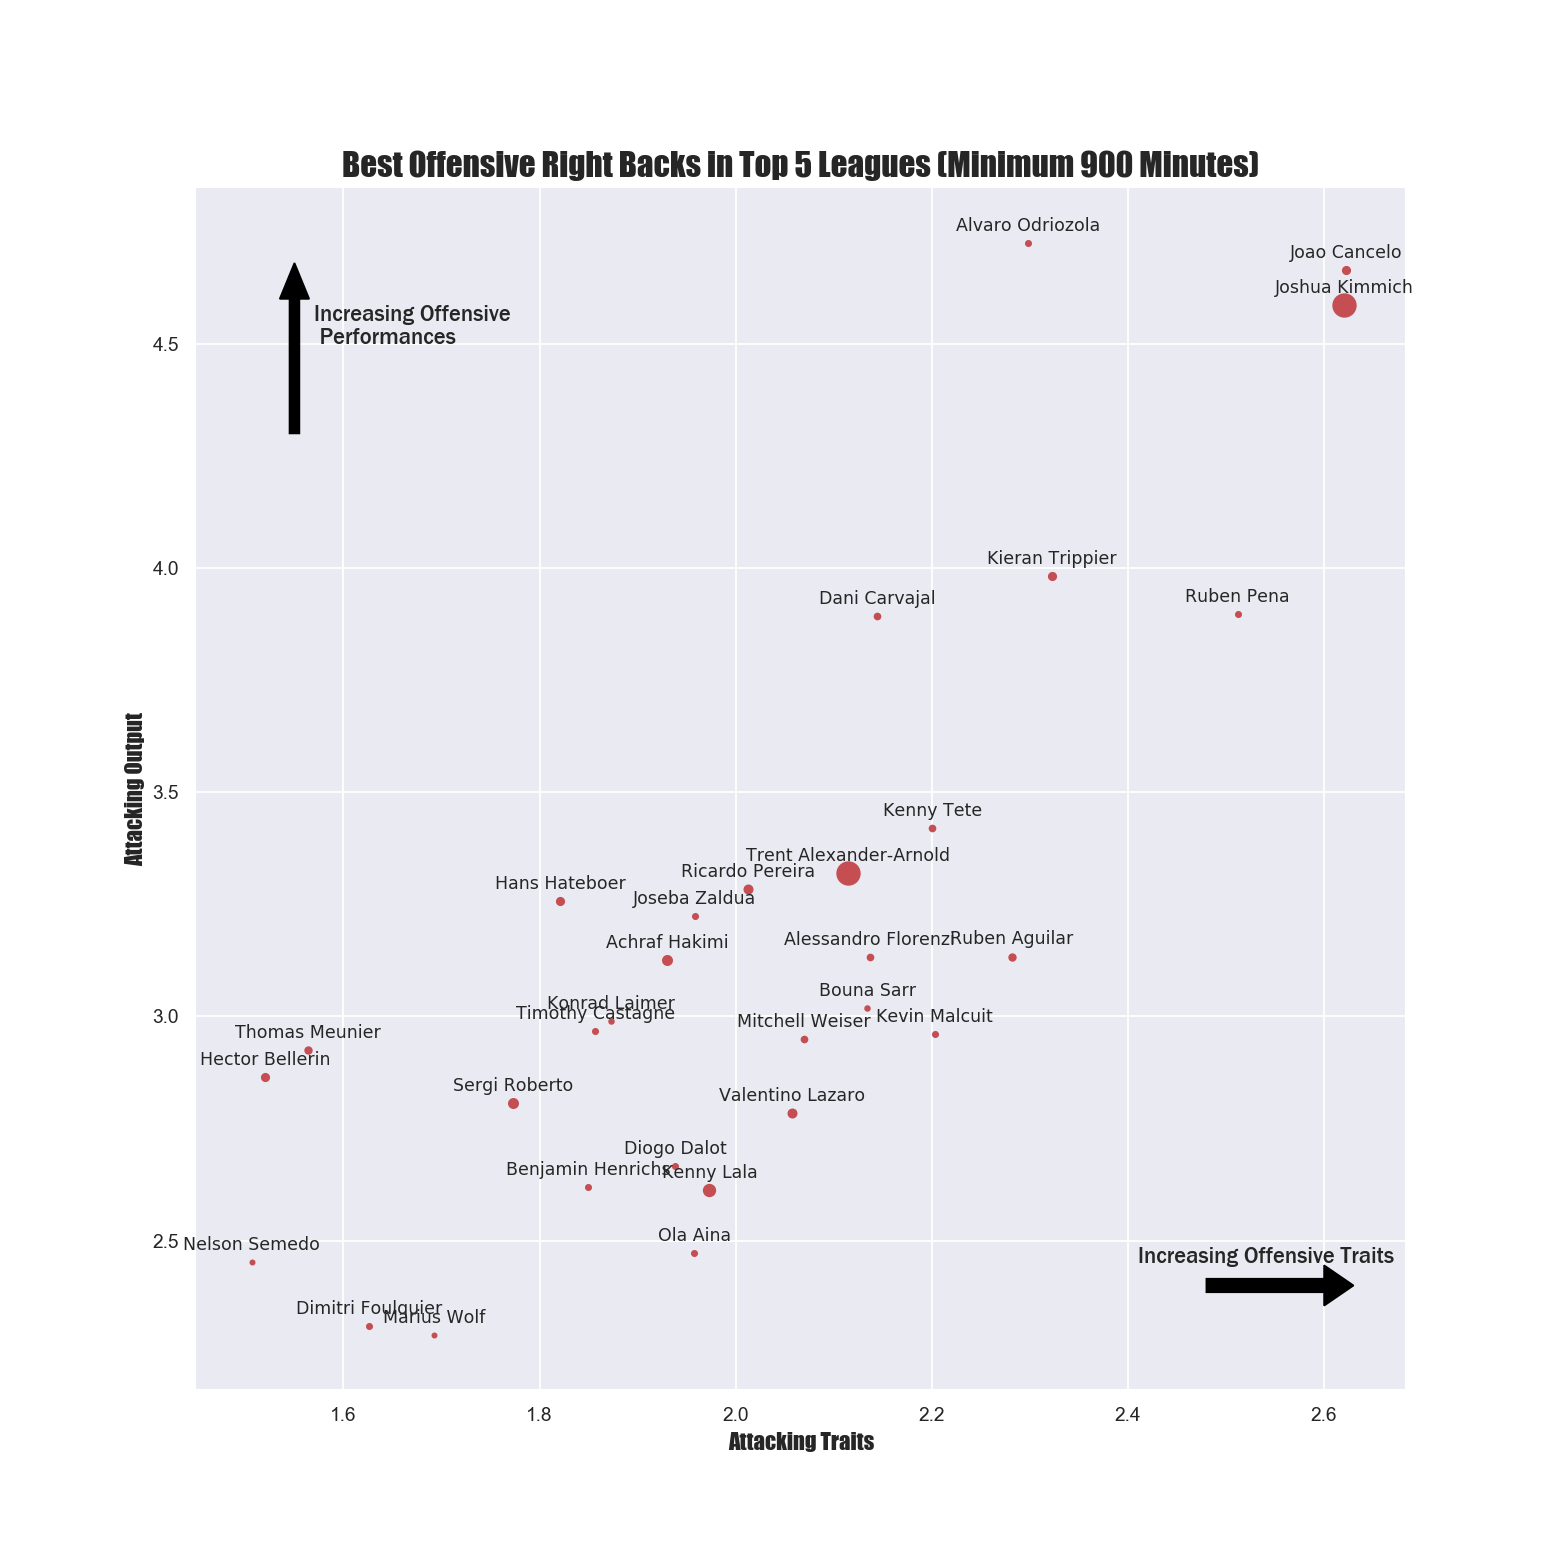

In [25]:
sns.set()

fig = plt.figure(figsize = (12.5, 12.5))


vdf = vdf.sort_values(by = 'SumWt', ascending=True)
n = vdf['Player'].values

ixs = vdf.index
x = vdf['SumWt'].values
y = vdf['SumVal'].values

#sz = vdf['P%'].values
sz = adf.iloc[ixs]['A'].values + 8

hfont = {'fontname':'Helvetica'}
config = {
    'ha': 'center', 
    'va': 'center'
}

for i, txt in enumerate(n):
    if i != 0:
        disx = x[i] - x[i-1]
        if disx > 0.0001:
            plt.scatter(x[i], y[i], c = 'r', s= (1.25)**sz[i])
            plt.text(x[i], y[i]+ 0.038, txt,config,  fontsize = 10, rotation = 0, family = 'MS Gothic')
    else:
        plt.scatter(x[i], y[i], c = 'r', s= (1.25)**sz[i])
        plt.text(x[i], y[i]+ 0.038, txt, config,  fontsize = 10, rotation = 0, family = 'MS Gothic')

plt.arrow(2.48, 2.4, 0.12, 0, width = 0.03, head_length = 0.03, color = 'black')
plt.text(2.41, 2.45, "Increasing Offensive Traits", fontsize = 13, family = "Franklin Gothic Medium")

plt.arrow(1.55, 4.3, 0, 0.3, width = 0.01, head_length = 0.08, color = 'black' )
plt.text(1.57, 4.5, "Increasing Offensive\n Performances", fontsize = 13, family = "Franklin Gothic Medium")


plt.gcf().text(1.0, 0.01, "HI", fontsize=14, color = 'black')


fig = plt.gcf()
ax = plt.gca()
ax.set_xlabel('Attacking Traits', family = "Impact", fontsize = 13)
ax.set_ylabel('Attacking Output', family = "Impact", fontsize = 13)


ax.set_title('Best Offensive Right Backs in Top 5 Leagues (Minimum 900 Minutes)', family = 'Impact', fontsize = 19)
fig.savefig('rb.jpg', dpi = 500)

## Provide Ranking System

In [26]:
xdf.set_index('Player').loc['Diogo Dalot']

Club       Manchester Utd
Country          Portugal
MIN                  1257
Age                    20
FS90             0.143198
CC90              1.28878
DR90              1.14558
TBOX90            1.64678
CRrat90           1.46181
SumVal            2.66677
SumWt             1.93812
Name: Diogo Dalot, dtype: object

In [27]:
def get_ranks(df, sts90):
    for i in sts90:
        df[i + ' Rank'] = df[i].rank(ascending = False)
        
    return df
t = get_ranks(xdf, sts90)

In [28]:
sts90

['FS90', 'CC90', 'DR90', 'TBOX90', 'CRrat90']

In [57]:
t.set_index('Player').loc['Joshua Kimmich']

Club            FC Bayern
Country           Germany
MIN                  3690
Age                    24
FS90              1.60976
CC90              2.39024
DR90              0.97561
TBOX90            1.63415
CRrat90           1.02325
SumVal            4.58704
SumWt             2.62019
FS90 Rank               6
CC90 Rank               1
DR90 Rank              28
TBOX90 Rank            27
CRrat90 Rank           13
Name: Joshua Kimmich, dtype: object

In [56]:
original_df.sort_values(by = 'A', ascending = False)

,,,,MIN,A,ACR,FS,CR,AP,ACRO,CC,P,DR,TBOX,CRrat,P%
Player,Country,Age,Club,,,,,,,,,,,,,
Joshua Kimmich,Germany,24.0,FC Bayern,3690.0,15.0,88.0,66.0,299.0,2996.0,24.0,98.0,2709.0,40.0,67.0,41.953177,90.420561
Trent Alexander-Arnold,England,20.0,Liverpool,3296.0,15.0,79.0,10.0,266.0,2208.0,47.0,69.0,1660.0,21.0,54.0,59.684211,75.181159
Kenny Lala,France,27.0,RC Strasbourg,2970.0,9.0,48.0,36.0,199.0,1591.0,26.0,62.0,1281.0,35.0,27.0,27.517588,80.515399
Dani Alves,Brazil,36.0,Paris,1805.0,7.0,18.0,32.0,71.0,1584.0,17.0,35.0,1356.0,18.0,42.0,17.253521,85.606061
Sergi Roberto,Spain,27.0,FC Barcelona,2796.0,7.0,7.0,42.0,34.0,2128.0,7.0,34.0,1922.0,21.0,78.0,5.764706,90.319549
Jonathan Schmid,France,28.0,FC Augsburg,2610.0,7.0,40.0,22.0,124.0,1057.0,15.0,48.0,863.0,16.0,18.0,24.395161,81.646168
Achraf Hakimi,Morocco,20.0,Dortmund,2110.0,7.0,8.0,44.0,55.0,1683.0,8.0,17.0,1445.0,43.0,45.0,4.654545,85.858586
Valentino Lazaro,Austria,23.0,Hertha BSC,2743.0,6.0,45.0,28.0,156.0,1205.0,17.0,55.0,920.0,34.0,45.0,24.641026,76.348548
Lukasz Piszczek,Poland,33.0,Dortmund,2208.0,6.0,15.0,12.0,41.0,1392.0,15.0,22.0,1163.0,9.0,34.0,21.951220,83.548851


### Best U23 Prospects

In [119]:
logic = (df['MIN'] > 900) & (df['Age'] < 24.0)
xdf = df[logic].sort_values(by = 'SumVal', ascending = False)


pdf = xdf.iloc[:20]
pdf = pdf.drop(130, axis = 'index')
pdf = pdf.drop(72, axis = 'index')

In [120]:
pdf

,Player,Club,Country,MIN,Age,FS90,CC90,DR90,TBOX90,CRrat90,SumVal,SumWt
6,Alvaro Odriozola,Real Madrid,Spain,1406.0,23.0,1.344239,1.344239,0.576102,3.520626,0.618167,4.724676,2.298110
69,Kenny Tete,OL,Netherlands,1246.0,23.0,1.011236,1.516854,0.216693,2.166934,1.450288,3.420707,2.200283
122,Trent Alexander-Arnold,Liverpool,England,3296.0,20.0,0.273058,1.884102,0.573422,1.474515,1.629727,3.320422,2.114960
1,Achraf Hakimi,Dortmund,Morocco,2110.0,20.0,1.876777,0.725118,1.834123,1.919431,0.198535,3.126722,1.930242
119,Timothy Castagne,Atalanta,Belgium,1911.0,23.0,0.659341,1.224490,0.894819,2.731554,0.493221,2.967695,1.856816
125,Valentino Lazaro,Hertha BSC,Austria,2743.0,23.0,0.918702,1.804594,1.115567,1.476486,0.808492,2.784007,2.057646
37,Diogo Dalot,Manchester Utd,Portugal,1257.0,20.0,0.143198,1.288783,1.145585,1.646778,1.461814,2.666766,1.938121
14,Benjamin Henrichs,AS Monaco,Germany,2097.0,22.0,2.060086,0.987124,0.557940,1.630901,0.527507,2.620207,1.849411
94,Ola Aina,Torino,Nigeria,2067.0,22.0,1.611030,0.957910,1.306241,1.523948,0.755701,2.472240,1.957871
81,Marius Wolf,Dortmund,Germany,1042.0,23.0,1.295585,0.950096,1.209213,1.986564,0.178317,2.289482,1.692520


<IPython.core.display.Javascript object>


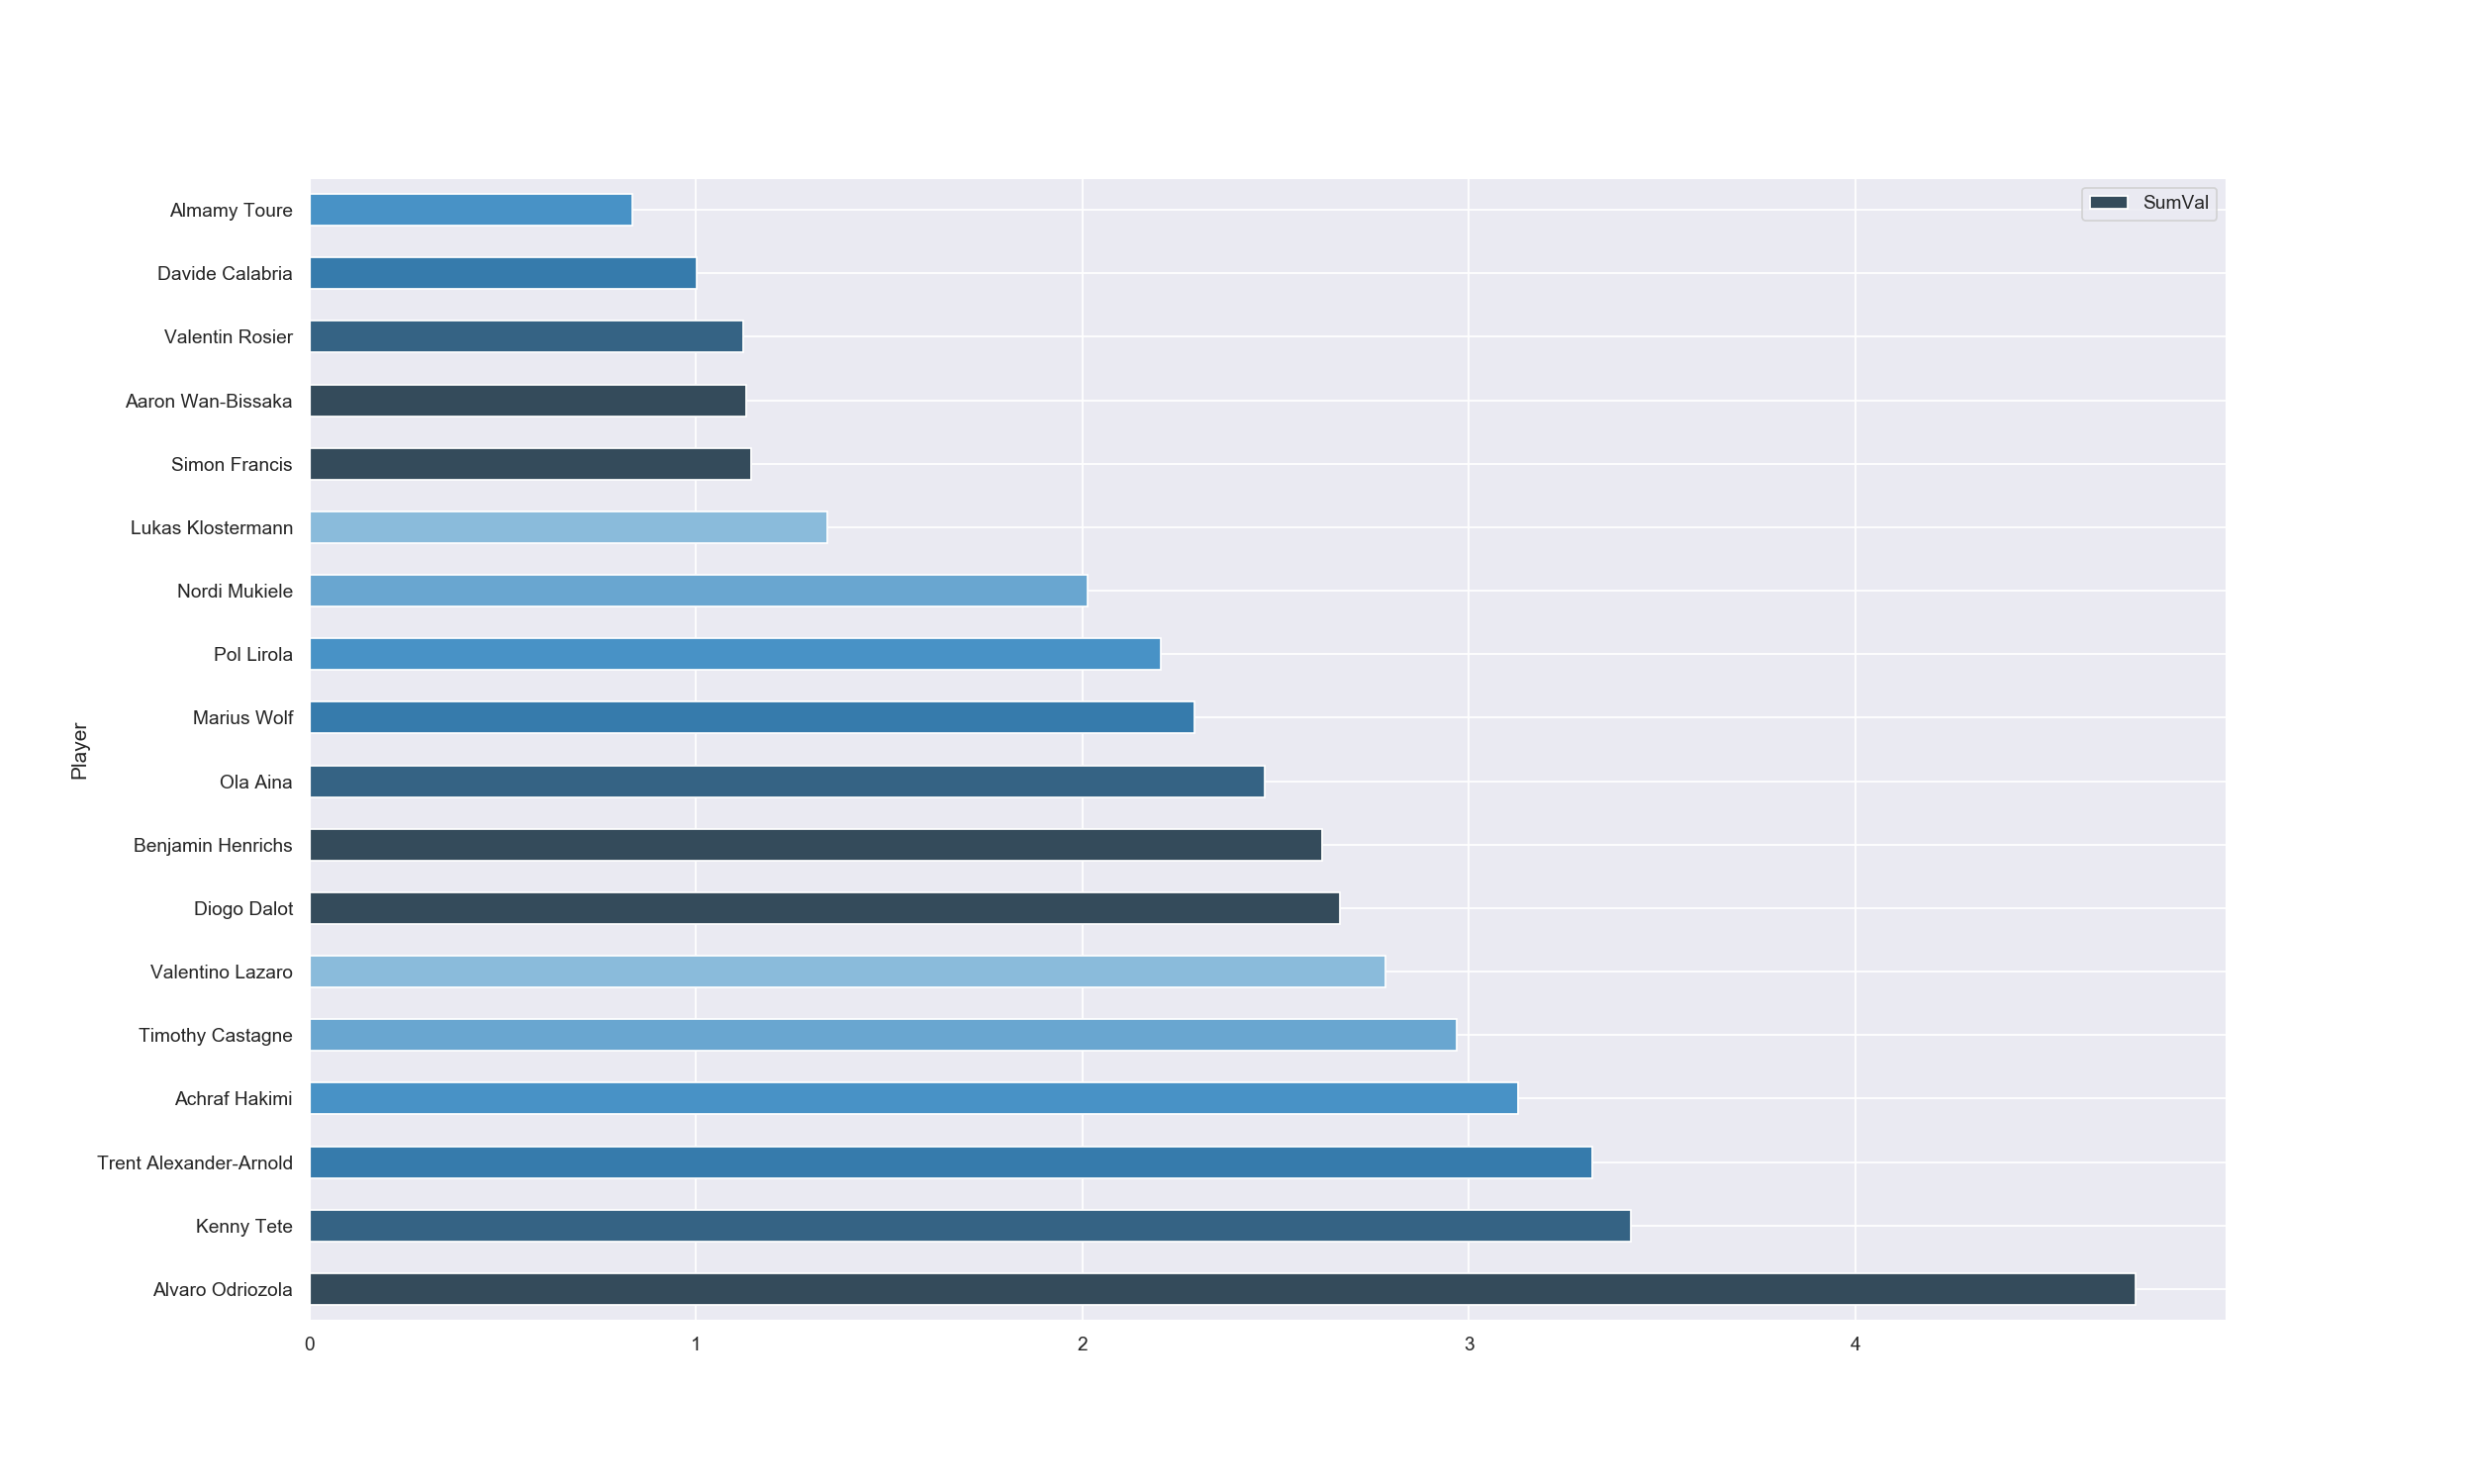

In [141]:
sns.set()

sns.set_palette('Blues_d')

ax = pdf.plot.barh('Player', 'SumVal', figsize = (20, 12))

In [117]:
ax.set_xlabel('Attacking Output', fontsize = 14, family = 'Impact')
ax.set_ylabel('Player', fontsize = 14, family = 'Impact')
ax.set_title('Best Offensive Right Backs (Under 23) in Top 5 Leagues (Minimum 900 Minutes)', family = 'Impact', fontsize = 19)

In [116]:
plt.gcf().savefig('rbu23.jpg', dpi = 500)

In [114]:
ax.legend('')

In [ ]:
a